In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from wordfreq import zipf_frequency
import seaborn as sns
import os
import pickle
import json
import joblib
from tqdm.notebook import tqdm

In [4]:
from parse_data import TextsinlevelsDB

In [5]:
model = "en_core_web_lg"
nlp = spacy.load(model)

In [6]:
textsinlevels = TextsinlevelsDB(db_name="textsinlevels")
df_news = textsinlevels.write_from_table_to_df("newsinlevels")
df_days = textsinlevels.write_from_table_to_df("daysinlevels")
del textsinlevels

In [7]:
LEVELS = ("A1", "A2", "B1", "B2", "C1", "C2")

In [8]:
class Text:
    def __init__(self, tokens):
        self.tokens = tokens
        self.lemmas = self.lemmatize()
        if len(self.lemmas) < 5:
            raise ValueError("The text must have at least 5 words")
        self.dependencies = self.get_dependencies()

    def lemmatize(self):
        return [token.lemma_.lower() for token in self.tokens if token.is_alpha]

    def count_words(self):
        n_words = 0
        for token in self.tokens:
            if token.is_alpha:
                n_words += 1
        return n_words

    def count_sentences(self):
        n_sentences = 0
        for _ in self.tokens.sents:
            n_sentences += 1
        return n_sentences

    def count_type_token_ratio(self):
        return len(set(self.lemmas)) / len(self.lemmas)

    def count_words_from_wordlist(self, wordlist):
        words_from_wordlists = 0

        for lemma in self.lemmas:
            if lemma in wordlist:
                words_from_wordlists += 1

        return words_from_wordlists / len(self.lemmas)

    def count_words_from_level_lists(self, word2level):
        level_freqs = {level: 0 for level in LEVELS}

        for lemma in self.lemmas:
            level = word2level.get(lemma)
            if level:
                level_freqs[level] += 1

        for level in level_freqs:
            level_freqs[level] /= len(self.lemmas)

        return level_freqs

    def count_zipf_freqs(self):
        zipf_freqs = {}

        for lemma in self.lemmas:
            zipf_freq = math.floor(zipf_frequency(lemma, "en"))
            if zipf_freq in zipf_freqs:
                zipf_freqs[zipf_freq] += 1
            else:
                zipf_freqs[zipf_freq] = 1

        for zipf_freq in zipf_freqs:
            zipf_freqs[zipf_freq] /= len(self.lemmas)

        return zipf_freqs

    def get_pos(self):
        return " ".join([token.pos_ for token in self.tokens if token.is_alpha])

    def get_dependencies(self):
        return " ".join([token.dep_ for token in self.tokens if token.is_alpha])

    def count_mean_noun_chunk_len(self):
        noun_chunks = list(self.tokens.noun_chunks)
        len_noun_chunks = [len(noun_chunk) for noun_chunk in noun_chunks]
        if len_noun_chunks:
            sum(len_noun_chunks) / len(noun_chunks)
        return 0

    def count_passiveness(self):
        active = 0
        passive = 0

        for dep in self.dependencies:
            if dep in {"aux", "csubj", "nsubj"}:
                active += 1
            elif dep in {"aux_pass", "csubjpass", "nsubjpass"}:
                passive += 1

        passiveness = 0

        if passive + active > 0:
            passiveness = passive / (active + passive)

        return passiveness

    def count_mean_num_dependencies(self):
        num_dependencies = 0
        for token in self.tokens:
            if token.is_alpha:
                for child in token.children:
                    if child.is_alpha:
                        num_dependencies += 1
        if self.dependencies:
            return num_dependencies / len(self.dependencies)
        return 0

    def count_mean_arc_len(self):
        sum_arc_len = 0
        n_arcs = 0
        for token in self.tokens:
            if token.is_alpha:
                for child in token.children:
                    if child.is_alpha:
                        sum_arc_len += abs(token.i - child.i) - 1
                        n_arcs += 1
        if n_arcs:
            return sum_arc_len / n_arcs
        return 0

    def create_df(self, abstract_nouns, concrete_nouns, word2level):
        dct = {
            "words": [" ".join(self.lemmas)],
            "word_count": [self.count_words()],
            "type_token_ratio": [self.count_type_token_ratio()],
            "abstract_nouns": [self.count_words_from_wordlist(abstract_nouns)],
            "concrete_nouns": [self.count_words_from_wordlist(concrete_nouns)],
            "pos": [self.get_pos()],
            "dep": [self.get_dependencies()],
            "mean_noun_chunk_len": [self.count_mean_noun_chunk_len()],
            "passiveness": [self.count_passiveness()],
            "mean_num_dependencies": [self.count_mean_num_dependencies()],
            "mean_arc_len": [self.count_mean_arc_len()],
        }

        zipf_freqs = self.count_zipf_freqs()

        for i in range(1, 7):
            dct[f"zipf_freqs_{i}"] = zipf_freqs.get(i, 0)

        levels = self.count_words_from_level_lists(word2level)
        for level in LEVELS:
            dct[level] = [levels[level]]

        df = pd.DataFrame(dct)
        return df

In [9]:
class TextDataset:
    def __init__(self, dataset, dataset_name, nlp, preprocess):
        self.dataset_name = dataset_name
        self.dataset = dataset
        if preprocess:
            docs = spacy.tokens.DocBin(store_user_data=False)
            for doc in nlp.pipe(tqdm(self.dataset["article_text"])):
                docs.add(doc)
            docs.to_disk(self.dataset_name)
        else:
            docs = spacy.tokens.DocBin().from_disk(self.dataset_name)
        self.texts = [Text(doc) for doc in docs.get_docs(spacy.blank("en").vocab)]
    
    def count_words(self):
        return [text.count_words() for text in self.texts]
    
    def count_sentences(self):
        return [text.count_sentences() for text in self.texts]
    
    def lemmatize(self):
        return [text.lemmatize() for text in self.texts]
    
    def count_type_token_ratio(self):
        return [text.count_type_token_ratio() for text in self.texts]
    
    def count_words_from_wordlist(self, wordlist):
        return [text.count_words_from_wordlist(wordlist) for text in self.texts]
    
    def count_words_from_level_lists(self, word2level):
        return [text.count_words_from_level_lists(word2level) for text in self.texts]
        
    def count_zipf_freqs(self):
        return [text.count_zipf_freqs() for text in self.texts]
                
    def show_counts_info(self):
        print(self.dataset_name)
        d = {"Number of words": self.count_words(),
            "Number of sentences": self.count_sentences()}
        df_stats = pd.DataFrame(d)
        print(df_stats.describe())

        f = plt.figure(figsize=(10, 4))
        plt.suptitle(self.dataset_name)
        gs = f.add_gridspec(1, 2)

        for i, col in enumerate(d):
            ax = f.add_subplot(gs[0, i])
            ax = sns.distplot(df_stats[col], bins=20)

        plt.show()
        f.savefig(f"{self.dataset_name}-words_sentences_counts.png")
    
    def get_pos(self):
        return [text.get_pos() for text in self.texts]
    
    def get_dependencies(self):
        return [text.get_dependencies() for text in self.texts]
    
    def count_mean_noun_chunk_len(self):
        return [text.count_mean_noun_chunk_len() for text in self.texts]
    
    def count_passiveness(self):
        return [text.count_passiveness() for text in self.texts]
    
    def count_mean_num_dependencies(self):
        return [text.count_mean_num_dependencies() for text in self.texts]
    
    def count_mean_arc_len(self):
        return [text.count_mean_arc_len() for text in self.texts]
    
    def create_df(self, abstract_nouns, concrete_nouns):
        dct = {"words": [" ".join(self.texts[i].lemmas) for i in range(len(self.texts))],
               "word_count": self.count_words(),
               "type_token_ratio": self.count_type_token_ratio(),
               "abstract_nouns": self.count_words_from_wordlist(abstract_nouns),
               "concrete_nouns": self.count_words_from_wordlist(concrete_nouns),
               "pos": self.get_pos(),
               "dep": self.get_dependencies(),
               "mean_noun_chunk_len": self.count_mean_noun_chunk_len(),
               "passiveness": self.count_passiveness(),
               "mean_num_dependencies": self.count_mean_num_dependencies(),
               "mean_arc_len": self.count_mean_arc_len(),
               "level": self.dataset["level"]}
                       
        zipf_freqs = self.count_zipf_freqs()
        
        for i in range(1, 7):
            dct[f"zipf_freqs_{i}"] = [dct.get(i, 0) for dct in zipf_freqs]
        
        for level in LEVELS:
            dct[level] = [dct[level] for dct in self.count_words_from_level_lists(word2level)]
        
        df = pd.DataFrame(dct)
        df["level"] = df["level"].map({1: 0, 2: 1, 3: 2}) 
        Y = df["level"]
        X = df.drop(columns=["level"])
        return X, Y

In [10]:
def preprocess_word_list(wordlist):
    with open(os.path.join("wordlists", f"{wordlist}.txt"), encoding="utf-8") as f:
        words_from_list = f.read().split("\n")
        
    words_from_list = " ".join([w for w in words_from_list if " " not in w and "-" not in w])
    words_from_list = nlp(words_from_list)
    words_from_list = set(w.lemma_.lower() for w in words_from_list)
    
    directory = "serialized"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(os.path.join(directory, f"{wordlist}.pkl"), "wb") as f:
        pickle.dump(words_from_list, f)

In [11]:
for wordlist in ("abstract_nouns", "concrete_nouns"):
    preprocess_word_list(wordlist)

In [12]:
def create_word2level_dct():
    dct = {}
    df = pd.read_csv(os.path.join("wordlists", "Vocabulary Framework – British English.csv"))
    sub_df = df[["Base Word", "Level"]]
    sub_df_min = sub_df.groupby("Base Word").min()
    for d, data in sub_df_min.reset_index().groupby("Level"):
        dct[d] = list(data["Base Word"])
    
    word2level = {}
    for level, words in dct.items():
        for i in range(len(words)):
            if ' ' not in words[i]:
                word2level[words[i].lower()] = level
                
    directory = "serialized"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(os.path.join("serialized", "word2level.json"), "w") as f:
        f.write(json.dumps(word2level))

In [13]:
create_word2level_dct()

In [14]:
with open(os.path.join("serialized", "abstract_nouns.pkl"), "rb") as f:
    abstract_nouns = pickle.load(f)
with open(os.path.join("serialized", "concrete_nouns.pkl"), "rb") as f:
    concrete_nouns = pickle.load(f)
with open(os.path.join("serialized", "word2level.json"), "r") as f:
    word2level = json.load(f)

In [15]:
news = TextDataset(dataset=df_news, dataset_name="news", nlp=nlp, preprocess=False)
X, Y = news.create_df(abstract_nouns, concrete_nouns)

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import mord

In [17]:
class MyTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, raw_documents, y=None):
        X = TfidfVectorizer.fit_transform(self, raw_documents, y=None)
        try:
            return X / X.sum(axis=1)
        except:
            return X
    
    def transform(self, raw_documents):
        X = TfidfVectorizer.transform(self, raw_documents)
        n_words = X.sum(axis=1)
        try:
            return X / X.sum(axis=1)
        except:
            return X

In [18]:
def visualize_coefs(estimator, n_top_features, filename):
     
    coef = estimator[-1].coef_
    n_classes = coef.shape[0]
    feature_names = np.array(estimator.named_steps['vectorizer'].get_feature_names())
    print(len(feature_names))
    

    for n in range(n_classes):
        print('class', n)
        coefs = np.argsort(coef[n])
        
        if len(feature_names) > 2 * n_top_features:
            # индексы признаков, получивших cамые большие положительные коэффициенты
            pos_coefs = coefs[-n_top_features:]

            # индексы признаков, получивших самые низкие отрицательные коэффициенты
            neg_coefs = coefs[:n_top_features]

            interesting_coefs = np.hstack([neg_coefs, pos_coefs])

            plt.figure(figsize=(9, 3))
            colors = ["red" if c < 0 else "green" for c in coef[n][interesting_coefs]]
            plt.bar(np.arange(2 * n_top_features), coef[n][interesting_coefs], color=colors)
            plt.xticks(np.arange(2 * n_top_features), feature_names[interesting_coefs], rotation=90, ha="right")
        else:
            colors = ["red" if c < 0 else "green" for c in coef[n][coefs]]
            plt.bar(np.arange(len(feature_names)), coef[n][coefs], color=colors)
            plt.xticks(np.arange(len(feature_names)), feature_names[coefs], rotation=90, ha="right")
            
        plt.savefig(f"{filename}_class{n}.png", bbox_inches="tight")
        plt.show()

In [19]:
def visualize_feature_importances(estimator, n_top_features, filename):
    coef = estimator[-1].feature_importances_
    feature_names = np.array(estimator.named_steps["vectorizer"].get_feature_names())
    word_importances = pd.Series(coef, index=feature_names).sort_values(ascending=False)[:10]
    word_importances.plot(kind="bar")
    plt.tight_layout()
    plt.savefig(f"{filename}.png", bbox_inches="tight")
    plt.show()

In [20]:
class PassthroughTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = X
        return X

    def get_feature_names(self):
        return self.X.columns.tolist()

In [21]:
def quality(y_actual, y_pred):
    acc = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred, average="macro")
    print(f"Accuracy: {acc:.4f}\nF1 macro: {f1:.4f}")
    
    cm = confusion_matrix(y_actual, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    return acc, f1

In [22]:
scaler = MaxAbsScaler()
vectorizer = MyTfidfVectorizer()

In [23]:
lr = LogisticRegression(solver="liblinear")
svm = LinearSVC()
tree = DecisionTreeClassifier()
adaboost = AdaBoostClassifier()
random_forest = RandomForestClassifier()
extra_trees = ExtraTreesClassifier()
lgbm = LGBMClassifier()
logistic_at = mord.LogisticAT()
logistic_it = mord.LogisticIT()
logistic_se = mord.LogisticSE()
ordinal_ridge = mord.OrdinalRidge()
lad = mord.LAD()

In [24]:
lr_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], lr__C=[0.1, 0.5, 1], lr__penalty=["l1", "l2"])
svm_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], svm__C=[0.01, 0.1, 1])
tree_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], tree__max_depth=[None, 7, 10],
                tree__min_samples_leaf=[1, 10])
adaboost_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], adaboost__base_estimator=[DecisionTreeClassifier(max_depth=1),
                        DecisionTreeClassifier(max_depth=2)])
random_forest_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], random_forest__max_depth=[None, 10],
                       random_forest__min_samples_leaf=[1, 5])
extra_trees_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], extra_trees__max_depth=[None, 15],
                       extra_trees__min_samples_leaf=[1, 15])
lgbm_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], lgbm__min_split_gain=[0, 0.5], lgbm__colsample_bytree=[0.25, 0.5, 1])
logistic_at_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], logistic_at__alpha=[0.5, 1, 5])
logistic_it_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], logistic_it__alpha=[0.5, 1, 5])
logistic_se_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], logistic_se__alpha=[0.5, 1, 5])
ordinal_ridge_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], ordinal_ridge__alpha=[0.5, 1, 5])
lad_params_lex = dict(vectorizer__word__min_df=[3, 5, 7], lad__C=[0.01, 0.1, 1])

In [25]:
lr_params_gram = dict(lr__C=[0.1, 0.5, 1], lr__penalty=["l1", "l2"])
svm_params_gram = dict(svm__C=[0.01, 0.1, 1])
tree_params_gram = dict(tree__max_depth=[None, 7, 10],
                tree__min_samples_leaf=[1, 10])
adaboost_params_gram = dict(adaboost__base_estimator=[DecisionTreeClassifier(max_depth=1),
                        DecisionTreeClassifier(max_depth=2)])
random_forest_params_gram = dict(random_forest__max_depth=[None, 10],
                       random_forest__min_samples_leaf=[1, 5])
extra_trees_params_gram = dict(extra_trees__max_depth=[None, 15],
                       extra_trees__min_samples_leaf=[1, 15])
lgbm_params_gram = dict(lgbm__min_split_gain=[0, 0.5], lgbm__colsample_bytree=[0.25, 0.5, 1])
logistic_at_params_gram = dict(logistic_at__alpha=[0.5, 1, 5])
logistic_it_params_gram = dict(logistic_it__alpha=[0.5, 1, 5])
logistic_se_params_gram = dict(logistic_se__alpha=[0.5, 1, 5])
ordinal_ridge_params_gram = dict(ordinal_ridge__alpha=[0.5, 1, 5])
lad_params_gram = dict(lad__C=[0.01, 0.1, 1])

In [26]:
clfs_lex = {
    "lr": [lr, lr_params_lex],
#     "svm": [svm, svm_params_lex],
#      "tree": [tree, tree_params_lex],
#     "adaboost": [adaboost, adaboost_params_lex],
#     "random_forest": [random_forest, random_forest_params_lex],
#     "extra_trees": [extra_trees, extra_trees_params_lex],
#     "lgbm": [lgbm, lgbm_params_lex],
#      "lad": [lad, lad_params_lex],
#     "ordinal_ridge": [ordinal_ridge, ordinal_ridge_params_lex],
#     "logistic_se": [logistic_se, logistic_se_params_lex],
#     "logistic_at": [logistic_at, logistic_at_params_lex],
#     "logistic_it": [logistic_it, logistic_it_params_lex],
}

In [27]:
clfs_gram = {
    "lr": [lr, lr_params_gram],
#     "svm": [svm, svm_params_gram],
#     "tree": [tree, tree_params_gram],
#     "adaboost": [adaboost, adaboost_params_gram],
#     "random_forest": [random_forest, random_forest_params_gram],
#     "extra_trees": [extra_trees, extra_trees_params_gram],
#     "lgbm": [lgbm, lgbm_params_gram],
#     "lad": [lad, lad_params_gram],
#     "ordinal_ridge": [ordinal_ridge, ordinal_ridge_params_gram],
#     "logistic_se": [logistic_se, logistic_se_params_gram],
#     "logistic_at": [logistic_at, logistic_at_params_gram],
#     "logistic_it": [logistic_it, logistic_it_params_gram],
}

In [28]:
clfs_all = clfs_lex

In [29]:
tree_based = {"tree", "adaboost", "random_forest", "extra_trees", "lgbm"}
with_coefs = {"lr", "svm"}

In [30]:
lexical_features = ['zipf_freqs_1', 'zipf_freqs_2', 'zipf_freqs_3', 'zipf_freqs_4',
       'zipf_freqs_5', 'zipf_freqs_6', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2',
       'type_token_ratio', 'abstract_nouns', 'concrete_nouns']

grammatical_features = ["mean_noun_chunk_len",
                        "passiveness",
                        "mean_num_dependencies",
                        "mean_arc_len"]

In [31]:
column_trans_lex = ColumnTransformer(
            [("word", vectorizer, "words"),
             ("lex", PassthroughTransformer(), lexical_features)])

column_trans_gram = ColumnTransformer(
            [("pos", MyTfidfVectorizer(), "pos"), 
             ("dep", MyTfidfVectorizer(), "dep"),
             ("gram", PassthroughTransformer(), grammatical_features)])

column_trans_all = ColumnTransformer(
            [("word", vectorizer, "words"), 
             ("pos", MyTfidfVectorizer(), "pos"),
             ("dep", MyTfidfVectorizer(), "dep"),
             ("feature", PassthroughTransformer(), lexical_features + grammatical_features)])

In [32]:
features = {"lexical": {"clfs": clfs_lex, "column_trans": column_trans_lex},
            "grammatical": {"clfs": clfs_gram, "column_trans": column_trans_gram},
            "all": {"clfs": clfs_all, "column_trans": column_trans_all}}

In [33]:
results = {}

for feature_set in features:
    results[feature_set] = {"F1 macro (validation)": {},
                        "Best params": {},
                        "Accuracy (test)": {},
                        "F1 macro (test)": {}
                       }

In [34]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    train_size=0.8, 
                                                    random_state=42,
                                                   stratify=Y)

In [36]:
def classification(feature_set, clfs, column_trans):
    directories = ("illustrations", "models", "results")
    nested_directories = tuple(os.path.join(directory, feature_set) for directory in directories)
    for directory in nested_directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
            
    for clf_name, clf_params in clfs.items():
        clf, params = clf_params
        if clf_name in tree_based:
            pipeline = Pipeline(steps=[("vectorizer", column_trans), (clf_name, clf)])
        else:
            pipeline = Pipeline(steps=[("vectorizer", column_trans), ("scaler", scaler), (clf_name, clf)])
        grid_search = GridSearchCV(pipeline, param_grid=params,
                               scoring={"F1": "f1_macro", "Accuracy": "accuracy"},
                               refit="F1", return_train_score=True, cv=skf, verbose=10) 
        grid_search.fit(X_train, y_train)
        best_f1_val = round(grid_search.best_score_, 4)
        best_params = grid_search.best_params_
        print(feature_set)
        print(clf)
        print(f"Best f1 on validation: {best_f1_val}")
        print("Best parameters:", best_params, "\n")
        estimator = grid_search.best_estimator_
        
        joblib.dump(grid_search, os.path.join("serialized", f"{feature_set}-{clf_name}.joblib"))
        y_pred_test = estimator.predict(X_test)
        acc, f1 = quality(y_test, y_pred_test)

        for metric, value in {"F1 macro (validation)": best_f1_val,
                              "Best params": best_params,
                              "Accuracy (test)": round(acc, 4),
                              "F1 macro (test)": round(f1, 4)}.items():
            results[feature_set][metric][clf_name] = value
        
        illustration_path = os.path.join("illustrations", feature_set, f"_{clf_name}")
        if clf_name in tree_based:
            visualize_feature_importances(estimator, 10, illustration_path)
        elif clf_name in with_coefs:
            visualize_coefs(estimator, 10, illustration_path)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 1/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.812, test=0.815) F1: (train=0.810, test=0.812) total time=   4.3s
[CV 2/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 2/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.819, test=0.794) F1: (train=0.816, test=0.793) total time=   3.6s
[CV 3/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 3/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.816, test=0.808) F1: (train=0.814, test=0.806) total time=   3.6s
[CV 4/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 4/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.816, test=0.810) F1: (train=0.814, test=0.807

[CV 3/4; 9/18] END lr__C=0.5, lr__penalty=l1, vectorizer__word__min_df=7; Accuracy: (train=0.881, test=0.858) F1: (train=0.880, test=0.857) total time=   4.7s
[CV 4/4; 9/18] START lr__C=0.5, lr__penalty=l1, vectorizer__word__min_df=7......
[CV 4/4; 9/18] END lr__C=0.5, lr__penalty=l1, vectorizer__word__min_df=7; Accuracy: (train=0.884, test=0.840) F1: (train=0.883, test=0.838) total time=   5.3s
[CV 1/4; 10/18] START lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3.....
[CV 1/4; 10/18] END lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3; Accuracy: (train=0.965, test=0.844) F1: (train=0.965, test=0.842) total time=   3.0s
[CV 2/4; 10/18] START lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3.....
[CV 2/4; 10/18] END lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3; Accuracy: (train=0.965, test=0.829) F1: (train=0.965, test=0.827) total time=   3.0s
[CV 3/4; 10/18] START lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3.....
[CV 3/4; 10/18] END lr__C=0.5, lr__pen

[CV 2/4; 18/18] END lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7; Accuracy: (train=0.973, test=0.824) F1: (train=0.973, test=0.822) total time=   2.5s
[CV 3/4; 18/18] START lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7.......
[CV 3/4; 18/18] END lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7; Accuracy: (train=0.971, test=0.853) F1: (train=0.971, test=0.852) total time=   2.5s
[CV 4/4; 18/18] START lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7.......
[CV 4/4; 18/18] END lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7; Accuracy: (train=0.970, test=0.831) F1: (train=0.970, test=0.830) total time=   2.2s
lexical
LogisticRegression(solver='liblinear')
Best f1 on validation: 0.8521
Best parameters: {'lr__C': 1, 'lr__penalty': 'l1', 'vectorizer__word__min_df': 7} 

Accuracy: 0.8529
F1 macro: 0.8523


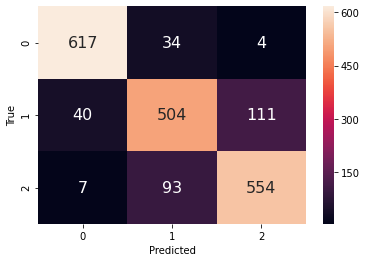

4803
class 0


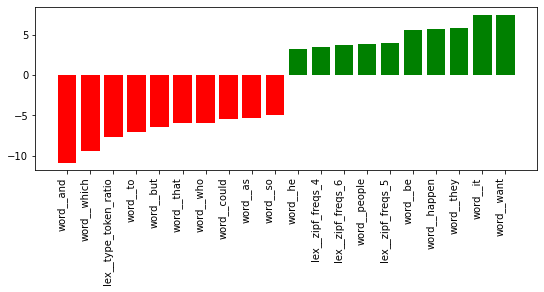

class 1


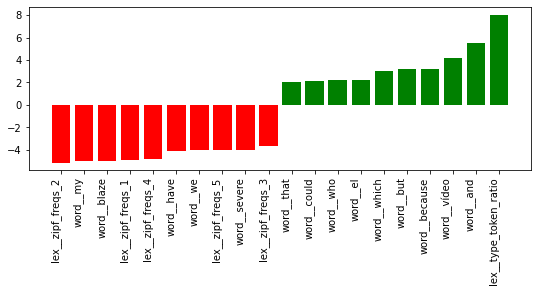

class 2


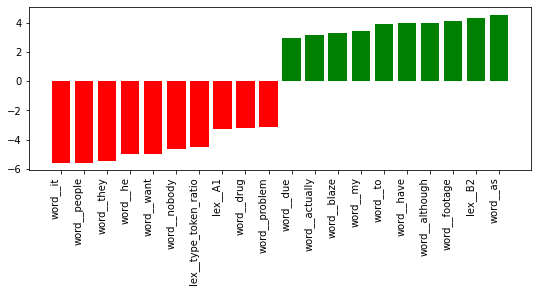

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 1/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.871, test=0.877) F1: (train=0.869, test=0.874) total time=   2.3s
[CV 2/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 2/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.871, test=0.876) F1: (train=0.869, test=0.874) total time=   2.2s
[CV 3/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 3/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.873, test=0.879) F1: (train=0.871, test=0.878) total time=   2.0s
[CV 4/4; 1/6] START lr__C=0.1, lr__penalty=l1...................................
[CV 4/4; 1/6] END lr__C=0.1, lr__penalty=l1; Accuracy: (train=0.876, test=0.859) F1: (train=0.874, test=0.857) total time=   2.0s
[CV 1/4; 2/6] START lr__C=0.1, lr__penalty=l2...................................
[CV 1/4; 2/6] E

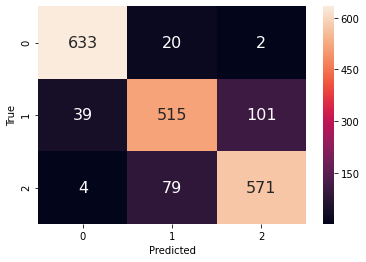

62
class 0


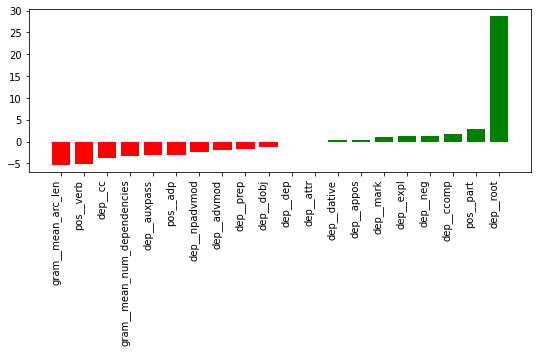

class 1


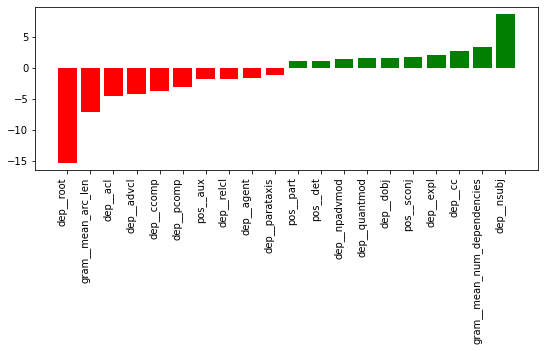

class 2


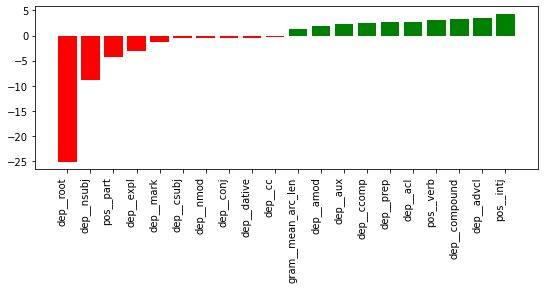

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 1/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.896, test=0.901) F1: (train=0.896, test=0.900) total time=   4.8s
[CV 2/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 2/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.898, test=0.895) F1: (train=0.897, test=0.894) total time=   4.8s
[CV 3/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 3/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.901, test=0.898) F1: (train=0.900, test=0.898) total time=   4.8s
[CV 4/4; 1/18] START lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3......
[CV 4/4; 1/18] END lr__C=0.1, lr__penalty=l1, vectorizer__word__min_df=3; Accuracy: (train=0.899, test=0.888) F1: (train=0.898, test=0.887

[CV 3/4; 9/18] END lr__C=0.5, lr__penalty=l1, vectorizer__word__min_df=7; Accuracy: (train=0.931, test=0.917) F1: (train=0.930, test=0.917) total time=   5.6s
[CV 4/4; 9/18] START lr__C=0.5, lr__penalty=l1, vectorizer__word__min_df=7......
[CV 4/4; 9/18] END lr__C=0.5, lr__penalty=l1, vectorizer__word__min_df=7; Accuracy: (train=0.929, test=0.909) F1: (train=0.929, test=0.909) total time=   5.4s
[CV 1/4; 10/18] START lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3.....
[CV 1/4; 10/18] END lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3; Accuracy: (train=0.976, test=0.891) F1: (train=0.976, test=0.889) total time=   4.6s
[CV 2/4; 10/18] START lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3.....
[CV 2/4; 10/18] END lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3; Accuracy: (train=0.979, test=0.886) F1: (train=0.979, test=0.886) total time=   4.6s
[CV 3/4; 10/18] START lr__C=0.5, lr__penalty=l2, vectorizer__word__min_df=3.....
[CV 3/4; 10/18] END lr__C=0.5, lr__pen

[CV 2/4; 18/18] END lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7; Accuracy: (train=0.984, test=0.883) F1: (train=0.984, test=0.882) total time=   3.8s
[CV 3/4; 18/18] START lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7.......
[CV 3/4; 18/18] END lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7; Accuracy: (train=0.981, test=0.896) F1: (train=0.981, test=0.895) total time=   3.8s
[CV 4/4; 18/18] START lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7.......
[CV 4/4; 18/18] END lr__C=1, lr__penalty=l2, vectorizer__word__min_df=7; Accuracy: (train=0.984, test=0.884) F1: (train=0.984, test=0.884) total time=   3.8s
all
LogisticRegression(solver='liblinear')
Best f1 on validation: 0.9113
Best parameters: {'lr__C': 0.5, 'lr__penalty': 'l1', 'vectorizer__word__min_df': 7} 

Accuracy: 0.9129
F1 macro: 0.9125


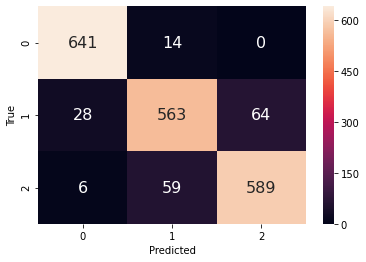

4865
class 0


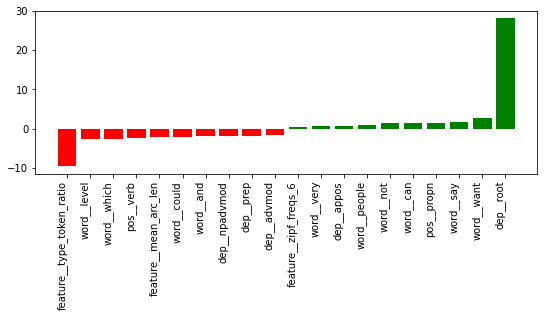

class 1


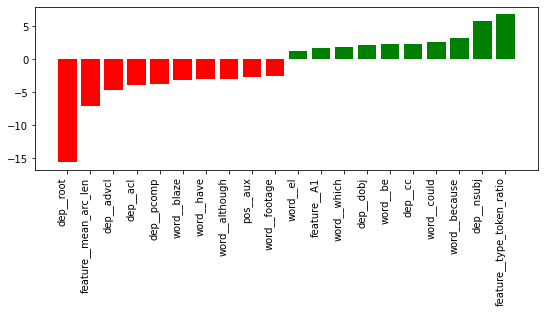

class 2


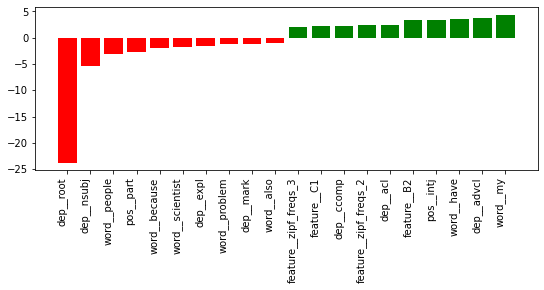

In [37]:
for feature_set, clfs_column_trans in features.items():
    clfs = clfs_column_trans["clfs"]
    column_trans = clfs_column_trans["column_trans"]
    classification(feature_set, clfs, column_trans)

In [38]:
baseline = y_test.value_counts(normalize=True).max()

In [39]:
def plot_different_classifiers(results, baseline, feature_set):
    mini_df = pd.DataFrame(results[feature_set])
    mini_df.to_csv(os.path.join("results", feature_set, f"{feature_set}-results.csv"))
    print(f"\n{feature_set}")
    mini_df[['Accuracy (test)', 'F1 macro (test)']].plot.bar()
    plt.axhline(y=baseline, color="k")
    plt.ylim(0, 1)
    plt.savefig(os.path.join("illustrations", feature_set, f"{feature_set}-results.png"), bbox_inches='tight')
    plt.show()
    
    max_value = 0
    best_clf = ""
    for clf, value in results[feature_set]["F1 macro (test)"].items():
        if value > max_value:
            best_clf = clf
            
    print("Best result:")
    print(best_clf)
    
    for metric in ("Accuracy (test)", "F1 macro (test)"):
        print(f"{metric}: {results[feature_set][metric][clf]}")
        
    return best_clf


lexical


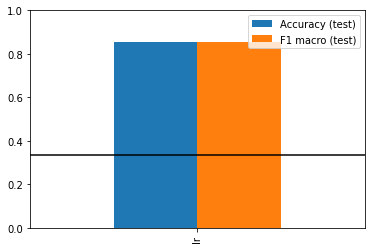

Best result:
lr
Accuracy (test): 0.8529
F1 macro (test): 0.8523

grammatical


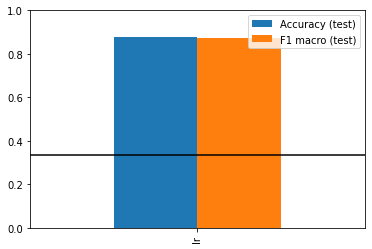

Best result:
lr
Accuracy (test): 0.8753
F1 macro (test): 0.8743

all


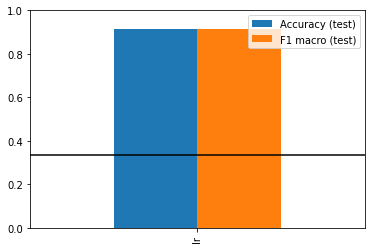

Best result:
lr
Accuracy (test): 0.9129
F1 macro (test): 0.9125


In [40]:
best_clfs = {}

for feature_set in features:
    best_clf = plot_different_classifiers(results, baseline, feature_set)
    best_clfs[feature_set] = best_clf

In [41]:
days = TextDataset(dataset=df_days, dataset_name="days", nlp=nlp, preprocess=False)
X, Y = days.create_df(abstract_nouns, concrete_nouns)

lexical-lr
Accuracy: 0.8113
F1 macro: 0.8082


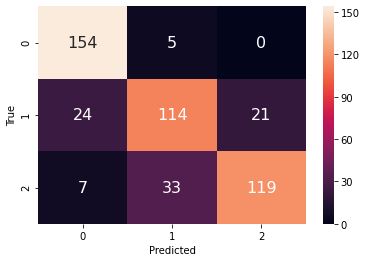

grammatical-lr
Accuracy: 0.7589
F1 macro: 0.7416


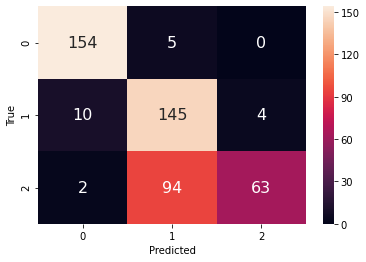

all-lr
Accuracy: 0.7673
F1 macro: 0.7570


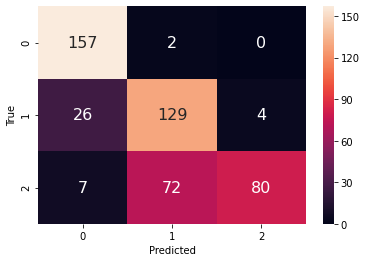

In [42]:
clf = "lr"

for feature_set in ("lexical", "grammatical", "all"):
    best_clf = best_clfs[feature_set]
    print(f"{feature_set}-{best_clf}")
    pipeline = joblib.load(os.path.join("serialized", f"{feature_set}-{best_clf}.joblib"))
    y_pred = pipeline.predict(X)
    quality(y_actual=Y, y_pred=y_pred)